# Dog Breeds

Create a model to enter the Dog Breeds competition at Kaggle. https://www.kaggle.com/c/dog-breed-identification .

In [1]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.transforms import tfms_from_model 
#from fastai.model import *
from fastai.dataset import get_cv_idxs
from fastai.conv_learner import *

In [3]:
PATH = "data/dogsbreeds/"

# Data Exploration 

## Initial exploration, create validation set.

In [4]:
import os
print(os.listdir(PATH))

['test2', 'test', 'tmp', 'labels.csv', '.Sources', 'sample_submission-2.csv', 'subm', 'train', 'models', '__MACOSX', 'shelter']


`labels.csv` is the (downloaded from Kaggle) source file with all the ids and labels.
There is no 'valid' directory, only train and test. So we need to create our own valid directory.
`get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42)` :
Get a random list of index values for Validation set from a dataset

In [4]:
label_csv = f'{PATH}labels.csv'    # the source file with the labeled samples from Kaggle
n = len(list(open(label_csv))) - 1 # number of labels, - 1 for the header
val_idxs = get_cv_idxs(n, val_pct=0.21) # 0.2 is default

In [5]:
testfn = len(os.listdir(PATH+'test'))
trainfn = len(os.listdir(PATH+'train'))
cvfn = len(val_idxs)
print("Number of images.  Training:",trainfn, "Validation:", cvfn, "Test:", testfn)

Number of images.  Training: 10222 Validation: 2146 Test: 10357


## Get the labels into a dataframe to Analyze data Frequency

In [6]:
import pandas as pd
label_df = pd.read_csv(label_csv)  # use pandas to get a label data frame
label_df.head()  # take a look at it

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

Notice that the id column is not a file name, as it is missing the suffx .jpg

In [8]:
label_df.describe()
#Generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values.

id               breed
count                              10222               10222
unique                             10222                 120
top     1674e551b6e45cdc27a3014ffb83f374  scottish_deerhound
freq                                   1                 126

In [9]:
#from IPython import display
#from pandas_summary import DataFrameSummary
#display(DataFrameSummary(label_df).summary())

So we have 10222 labels, matching the number of train images.
And we have 120 unique breeds. The top breed, (scottish_deerhound), has 126 images

In [10]:
v = label_df.apply(pd.Series.value_counts)['breed']
print("Number of labeled images per breed: Min=%d, Max=%d, mean=%d" % (v.min(), v.max(), v.mean()))

Number of labeled images per breed: Min=66, Max=126, mean=85


How do we deal with unbalanced dataset? This dataset has between 66 and 126 so it is a bit unbalanced, but not so much... (that JH would give it a second thought). Question: What is a good metric for "balanced"?  A recent paper suggests to deal with very unbalanced dataset by making copies of the rare cases.  TBD: Try to make copies of the rare cases to see how it affects?
Another paper [Training Deep Neural Networks on Imbalanced Data Sets](https://pdfs.semanticscholar.org/a0d8/6c44f2843a483dfffbfc03dda230bbaad4cc.pdf) suggests
a novel loss function called `mean squared false error` is proposed for the training of
deep networks on imbalanced data sets to effectively capture classification errors from both majority
class and minority class equally. 

In [11]:
# create sorted pivot table to see how many of each breed
#label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False)  

# Steps to Train the classifier

1. Enable data augmentation, and precompute=True
2. Use `lr_find()` to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use `lr_find()` again
8. Train full network with cycle_mult=2 until over-fitting

## Enable Data Augmentation

**How does the batch size affect training?** If we show less images (smaller batchsize), then it is calculating the gradient with less images — hence less accurate. In other words, knowing which direction to go and how far to go in that direction is less accurate. So as you make the batch size smaller, you are making it more volatile. It impacts the optimal learning rate that you would need to use, but in practice, dividing the batch size by 2 vs. 4 does not seem to change things very much. If you change the batch size by much, you can re-run learning rate finder to check.

In [7]:
sz=224  # default image size
arch=resnext101_64  #use resnext model
bs=100 #80 #56 # batch size

`max_zoom` — zoom in up to 1.1 times

In [8]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

`ImageClassifierData.from_csv` previously we used from_paths. Now labels are in CSV file.<br>
Arguments:
* path: a root path of the data (used for storing trained models, precomputed values, etc)
* trn: a tuple of training data matrix and target label/classification array (e.g. `trn=(x,y)` where `x` has the
                shape of `(5000, 784)` and `y` has the shape of `(5000,)`)
* val: a **tuple** of validation data matrix and target label/classification array.
* bs: batch size
* tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
* classes: a list of all labels/classifications
* num_workers: a number of workers
*  test: a matrix of test data (the shape should match `trn[0]`)

In [9]:
#Now from csv (previously was from paths)
data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test', 
                                    val_idxs=val_idxs, 
                                    suffix='.jpg', tfms=tfms, bs=bs)

In [15]:
len(data.classes), data.classes[:5]

(120,
 ['affenpinscher',
  'afghan_hound',
  'african_hunting_dog',
  'airedale',
  'american_staffordshire_terrier'])

Access to training dataset by `data.trn_ds`, which contains a lot of things including file names (`.fnames`)

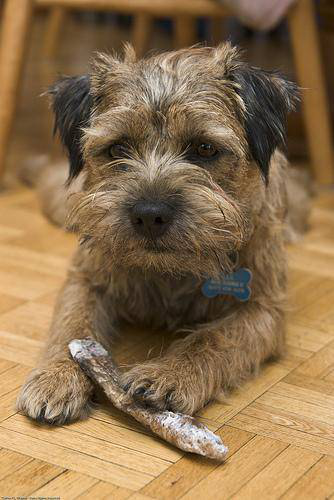

In [10]:
# select a random image example from the training set
import random
fn = PATH+data.trn_ds.fnames[random.randint(1,trainfn-cvfn)];  #print(fn)   
img = PIL.Image.open(fn); img

In [17]:
img.size

(500, 375)

###  Evaluate the image sizes 

- `img.size` how big is this image?
- `data.trn_ds.fnames` has all the names of the files in the training set.
- `PIL.Image.open(fp, mode='r')` Opens and identifies the given image file.
- `size_d` will be a dictionary (build as a comprehension, where k takes all the file names and becomes the key of the dictionary) of all the sizes of the training files.

- `(*size_d.values)` will unpack a list. 
- zip will pair up elements of tuples to create a list of tuples.

In [18]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}   
row_sz, col_sz = list(zip(*size_d.values()))  # pull all the sizes from the dictionary for each file
row_sz= np.array(row_sz); col_sz=np.array(col_sz)  #convert to np arrays

In [19]:
#row_sz[:6], col_sz[:6]  #take a look at the sizes of the first 6 images

In [20]:
#plt.hist(row_sz); plt.hist(col_sz);  #histogram of all values

In [21]:
#plt.hist(row_sz[row_sz<1000]); #Histogram of all rows below 1000

In [22]:
#plt.hist(col_sz[col_sz<1000]); #histogram of columns < 1000

## Find Learning Rate

In [23]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5) # what is the right .ps ?
#EX:12/9 dropout to 0 here to see how it affects learning rte
#Bigger network may require bigger dropout?
%time learn.lr_find()  

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      6.843236   863.18702  0.213886  

CPU times: user 2.95 s, sys: 1.6 s, total: 4.55 s
Wall time: 2.36 s


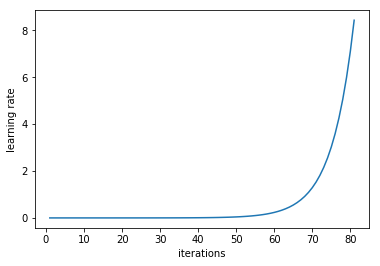

In [24]:
learn.sched.plot_lr() # plot of iterations?? versus learning rate

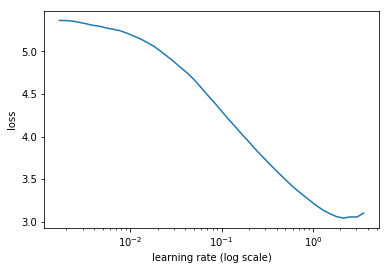

In [25]:
learn.sched.plot(n_skip=30)  # plot of loss versus learning rate, skip the first 30 iterations

The loss is still clearly improving at lr=10e-2 (0.01), so that's what we use. Recall that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

# Initial Model

To expedite things we want to do things with smaller images. JH usually starts with images of size 64 for fastest.
Later when he uses larger images, we need to use this to reduce the use of GPU RAM.
`get_data` gets the size and batchsize. 
It creates the `data` object using the usual transformation and classifier. 
It returns the data object if its size is > 300, else resize it to 340.

JH: *Reading the jpgs and resizing is slow for big images, so resizing them all to 340 first saves time.*
If sz > 300 we use it as it is in ‘train’, ‘valid’, ‘test’ folder.
and if the image size is less than 300, we resize it into 340 size and place it in /tmp folder. 


In [11]:
def get_data(sz,bs, val_idxs=val_idxs):  # sz=size, bs=batch size
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', label_csv, test_name='test',
                                        val_idxs=val_idxs, 
                                        suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz>300 else data.resize(340, 'tmp')

##  Pre-compute

In [27]:
# Uncomment to reset the precomputed activations
#!rm -rf {PATH}tmp

In [12]:
data = get_data(sz, bs)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

With precompute=True, data augmentation does not do anything because we are showing exactly the same activations each time.

In [13]:
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5) 

## Train last layer from precomputed activations for 1-2 epochs

In [14]:
lr = 1e-2

In [15]:
%time learn.fit(lr, 6)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.930012   0.643786   0.893756  
    1      0.888433   0.388865   0.910065                  
    2      0.541853   0.320895   0.912861                  
    3      0.418999   0.287425   0.913327                  
    4      0.347329   0.26778    0.921249                  
    5      0.297154   0.257732   0.926375                  

CPU times: user 21.4 s, sys: 11.7 s, total: 33.1 s
Wall time: 19.6 s


[array([0.25773]), 0.9263746586228128]

Results look good, so we turn precompute to False

## Train last layer with data augmentation 
(i.e. precompute=False) for 2-3 epochs with cycle_len=1.
This enables stochastic gradient descent with restarts (SGDR), ie **learning rate annealing**. As it gets closer to the minimal loss, start decreasing the learning rate ($\mu$) (taking smaller steps) to get to the right spot.

In [32]:
learn.precompute=False

In [33]:
%time learn.fit(lr, 6, cycle_len=1)  #cycle_len=1 is equal to epochs

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.338513   0.247163   0.924977  
    1      0.325959   0.241784   0.923579                  
    2      0.316746   0.239569   0.926841                  
    3      0.297612   0.23722    0.924511                  
    4      0.29502    0.235053   0.925443                  
    5      0.282112   0.232671   0.928239                  

CPU times: user 18min 1s, sys: 1min 39s, total: 19min 41s
Wall time: 9min 15s


[array([0.23267]), 0.9282385872994643]

This is **under**-fitting, as val_loss < trn_loss, so let increase the cycle_len.  If under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly). So we will add `cycle_mult=2` (i.e. 1st cycle is 1 epoch, 2nd cycle is 2 epochs, and 3rd cycle is 4 epochs)

In [34]:
%time learn.fit(lr, 4, cycle_len=2) 

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.281274   0.229552   0.925909  
    1      0.260189   0.228506   0.927773                  
    2      0.260004   0.224247   0.928705                  
    3      0.244767   0.221882   0.929637                  
    4      0.237477   0.223062   0.929637                  
    5      0.239462   0.220801   0.931034                  
    6      0.24197    0.223328   0.927307                  
    7      0.223532   0.221684   0.928239                  

CPU times: user 23min 47s, sys: 2min 11s, total: 25min 59s
Wall time: 12min 19s


[array([0.22168]), 0.9282385872994643]

In [35]:
learn.save('224_pre')
learn.load('224_pre')

## Steps 5-7 RETRAIN the earlier layers, in this case it is useless since the images are from Imagenet
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again

## Increase size of images
**Cool trick to avoid overfitting**: run first on smaller images, and then grow the data size.
Here we continue to train with larger images...
Imagenet used 224 and 299 sized images..?

In [36]:
#bs=90
learn.set_data(get_data(339, bs)) #299,bs))
learn.freeze()

In [37]:
%time learn.fit(1e-2, 6, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.270019   0.219387   0.926841  
    1      0.247073   0.216912   0.9315                    
    2      0.242749   0.213109   0.933364                  
    3      0.241651   0.211568   0.9315                    
    4      0.239109   0.209731   0.933364                  
    5      0.212338   0.210501   0.9315                    

CPU times: user 36min 55s, sys: 4min 5s, total: 41min
Wall time: 21min 59s


[array([0.2105]), 0.9315004695383945]

In [38]:
learn.save('339_pre')
learn.load('339_pre')

If it was **under**-fitting, then lets increase the cycle_len.  If under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly). So we will add `cycle_mult=2` (i.e. 1st cycle is 1 epoch, 2nd cycle is 2 epochs, and 3rd cycle is 4 epochs)
(But above is usually not underfitting...) 

In [39]:
%time learn.fit(lr, 4, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.210588   0.207323   0.93383   
    1      0.213834   0.207538   0.932432                  
    2      0.209975   0.203778   0.930569                  
    3      0.193783   0.204495   0.929637                  
    4      0.196425   0.203976   0.93383                   
    5      0.178653   0.204685   0.933364                  
    6      0.179159   0.205408   0.929637                  
    7      0.175453   0.202481   0.931034                  

CPU times: user 49min 17s, sys: 5min 22s, total: 54min 39s
Wall time: 29min 19s


[array([0.20248]), 0.9310344895356633]

When the validation loss and training loss are about the same — this is the right track.
So lets try data augmentation with TTA.

In [16]:
log_preds,y = learn.TTA()

In [17]:
probs = np.mean(np.exp(log_preds),0)
metrics.log_loss(y, probs), accuracy_np(probs, y)

(0.2577316251651753, 0.9263746505125815)

Other things to try:
- Try running one more cycle of 2 epochs
- Unfreezing (in this case, training convolutional layers did not help in the slightest since the images actually came from ImageNet)
- Remove validation set and just re-run the same steps, and submit that — which lets us use 100% of the data.

In [42]:
#one more time...
%time learn.fit(lr, 1, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.174943   0.202672   0.931966  
    1      0.169903   0.202446   0.934296                  

CPU times: user 12min 20s, sys: 1min 18s, total: 13min 39s
Wall time: 7min 19s


[array([0.20245]), 0.934296368997117]

In [43]:
#and again TTA
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
metrics.log_loss(y, probs), accuracy_np(probs, y)

(0.20058459247976176, 0.9356943150046598)

# Analyzing results on Validation Set:
looking at pictures

In [18]:
# this gives prediction (in log probabilities) for the validation set.  (WT=30s)
%time log_preds = learn.predict()
#log_preds.shape

CPU times: user 704 ms, sys: 403 ms, total: 1.11 s
Wall time: 689 ms


In [19]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to the breed classes 0 to 119
probs = np.exp(log_preds)        # probability of each dog-breed

In [46]:
log_preds.shape, preds.shape, probs.shape, data.val_y.shape

((2146, 120), (2146,), (2146, 120), (2146,))

How many images we miss-classified in the validation set?

In [20]:
assert(len(preds) == len(data.val_y))

In [21]:
missed_breeds = [] # np.asarray(data.classes,0) #for i in range(120)
accurate_breeds = []
mislabeled_images = 0
for i in range(cvfn):
    if (preds[i] == data.val_y[i]):
        accurate_breeds.append(preds[i])
    else:
        missed_breeds.append(data.val_y[i])
        mislabeled_images +=1
                             
missed_dict = {data.classes[i]:missed_breeds.count(i) for i in missed_breeds}
accurate_dict = {data.classes[i]:accurate_breeds.count(i) for i in accurate_breeds}
print("Number of breeds that were mis-classified:", len(missed_dict)), 
print("Images missclassified:", mislabeled_images, "out of:", cvfn, "ratio:", mislabeled_images / cvfn) #; missed_dict

Number of breeds that were mis-classified: 70
Images missclassified: 158 out of: 2146 ratio: 0.07362534948741846


In [49]:
%matplotlib inline
#from sklearn.metrics import confusion_matrix
#from fastai.plots import plot_confusion_matrix
#too many classes to be able to see in a confusion matrix.
#cm = confusion_matrix(data.val_y, preds)
#plot_confusion_matrix(cm, data.classes, normalize=True, figsize=(200,200))

### Auxiliary definitions for plotting

In [22]:
def rand_by_mask(n, mask): return np.random.choice(np.where(mask)[0], n, replace=False)
def rand_by_correct(n, is_correct): return rand_by_mask(n, (preds == data.val_y)==is_correct)

In [23]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [119]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [data.classes[np.argmax(probs[x])] for x in idxs]
    title_label = [data.classes[data.val_y[x]] for x in idxs] # get the true label
    #titleP = "TrueLabel:" + str(title_label) + "\nPredicted:" + str(title_probs)
    print(title, "Expected:", title_label)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

`data.val_y` contains the labels for the classes for each of the validation set images.
`preds` has the predicted labels.

### Explore which were correctly classified and which were not

Correctly classified.
 Expected: ['irish_wolfhound', 'black-and-tan_coonhound', 'japanese_spaniel', 'affenpinscher', 'pomeranian']


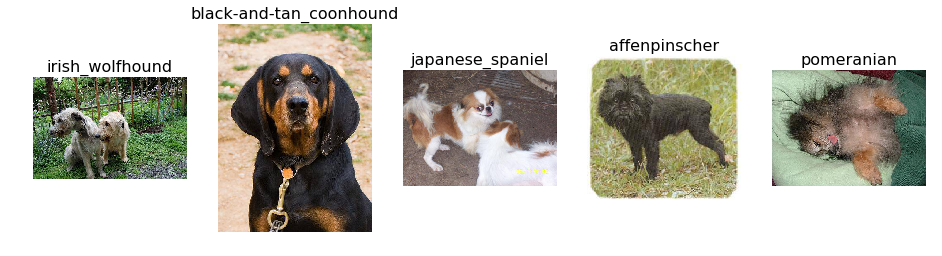

In [120]:
# 1. A few (e.g. 5) correct labels at random
plot_val_with_title(rand_by_correct(5, True), "Correctly classified.\n")

Incorrectly classified. Expected: ['siberian_husky', 'australian_terrier', 'golden_retriever', 'lakeland_terrier', 'saluki']


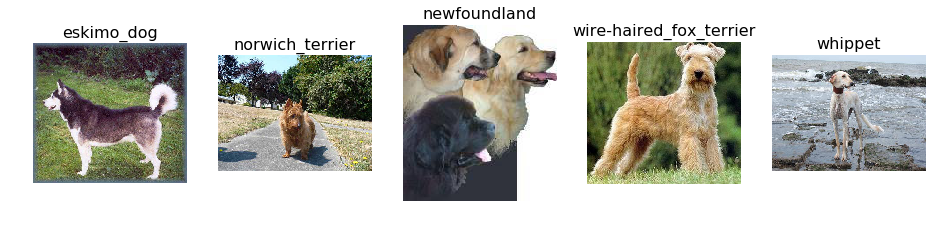

In [121]:
# 2. A few (e.g. 5) incorrect labels at random
plot_val_with_title(rand_by_correct(5, False), "Incorrectly classified.")

### Best and worst cases (TBD)
`most_by_correct` was designed for a binary classification. needs to be fixed.

In [56]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

In [57]:
#plot_val_with_title(most_by_correct(y ,True), "Most correct ")

In [58]:
#most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
#plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [109]:
def plot_most_confident(n=5, title=None, accurate=True, figsize=(40,30)):
    imgst = []
    titles = []

    maxp = np.zeros(cvfn)
    for i in range(cvfn): 
        eq = (preds[i] == data.val_y[i])
        if (accurate and eq):
            maxp[i] = max(probs[i])
        elif ((not accurate) and (not eq)):
            maxp[i] = max(probs[i])
    topnf = list(maxp.argsort()[-n:])
    smaxp = sorted(maxp)
    print(title, "Top prediction probs\n", smaxp[-n:])
    for f in topnf:
        fn = data.val_ds.fnames[f]
        ffn = f'{PATH}'+fn
        imgst.append(Image.open(ffn).resize((200,200))) 
        titles.append("Predicted:" + data.classes[preds[f]] + "\nTrue Label:" + data.classes[data.val_y[f]] ) 
    plots(imgst,titles=titles, rows=n//5,figsize=figsize)

Most Correct  Top prediction probs
 [0.9998960494995117, 0.9999008178710938, 0.9999008178710938, 0.9999008178710938, 0.9999027252197266, 0.9999103546142578, 0.9999160766601562, 0.9999179840087891, 0.9999237060546875, 0.9999256134033203, 0.9999275207519531, 0.9999465942382812, 0.9999656677246094, 0.9999675750732422, 0.9999790191650391]


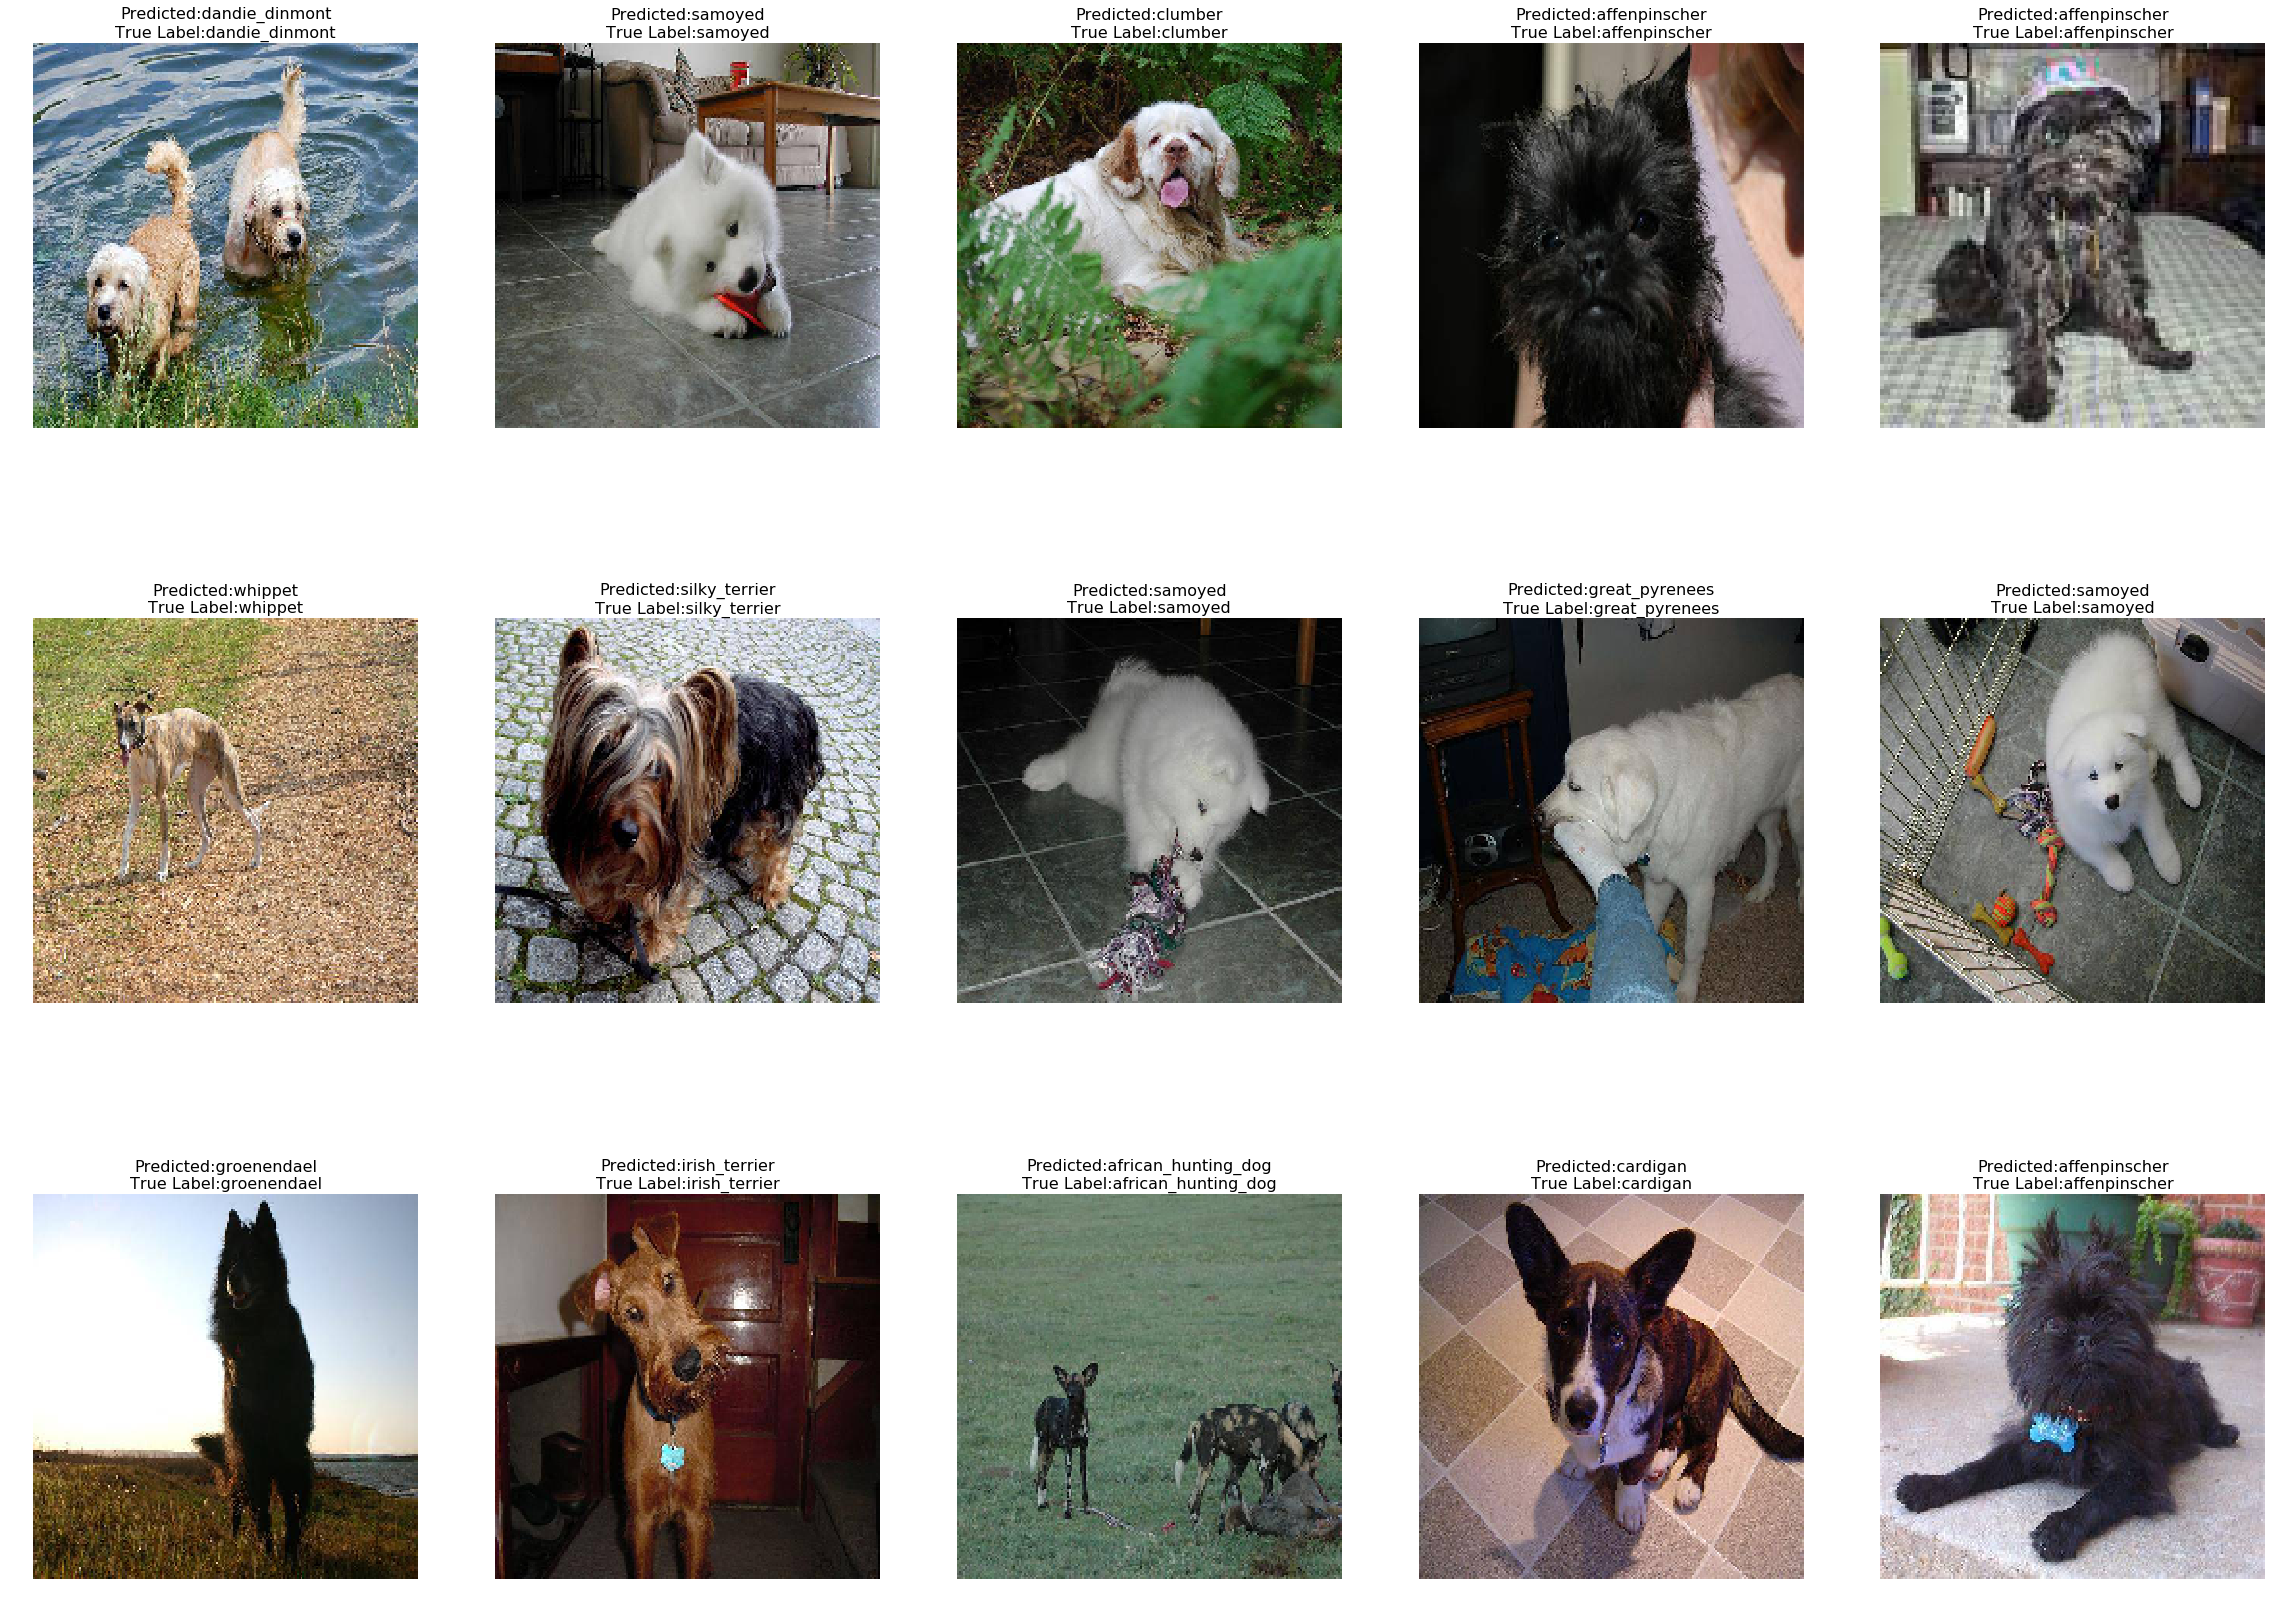

In [111]:
plot_most_confident(n=15, title="Most Correct ", accurate=True)

Most Wrong Top prediction probs
 [0.8718628883361816, 0.8729270100593567, 0.8792290687561035, 0.8803752064704895, 0.9012226462364197, 0.9030086994171143, 0.9156584143638611, 0.917998194694519, 0.9267479777336121, 0.9271705150604248, 0.9359246492385864, 0.9476707577705383, 0.9527217745780945, 0.9571760892868042, 0.9733961224555969]


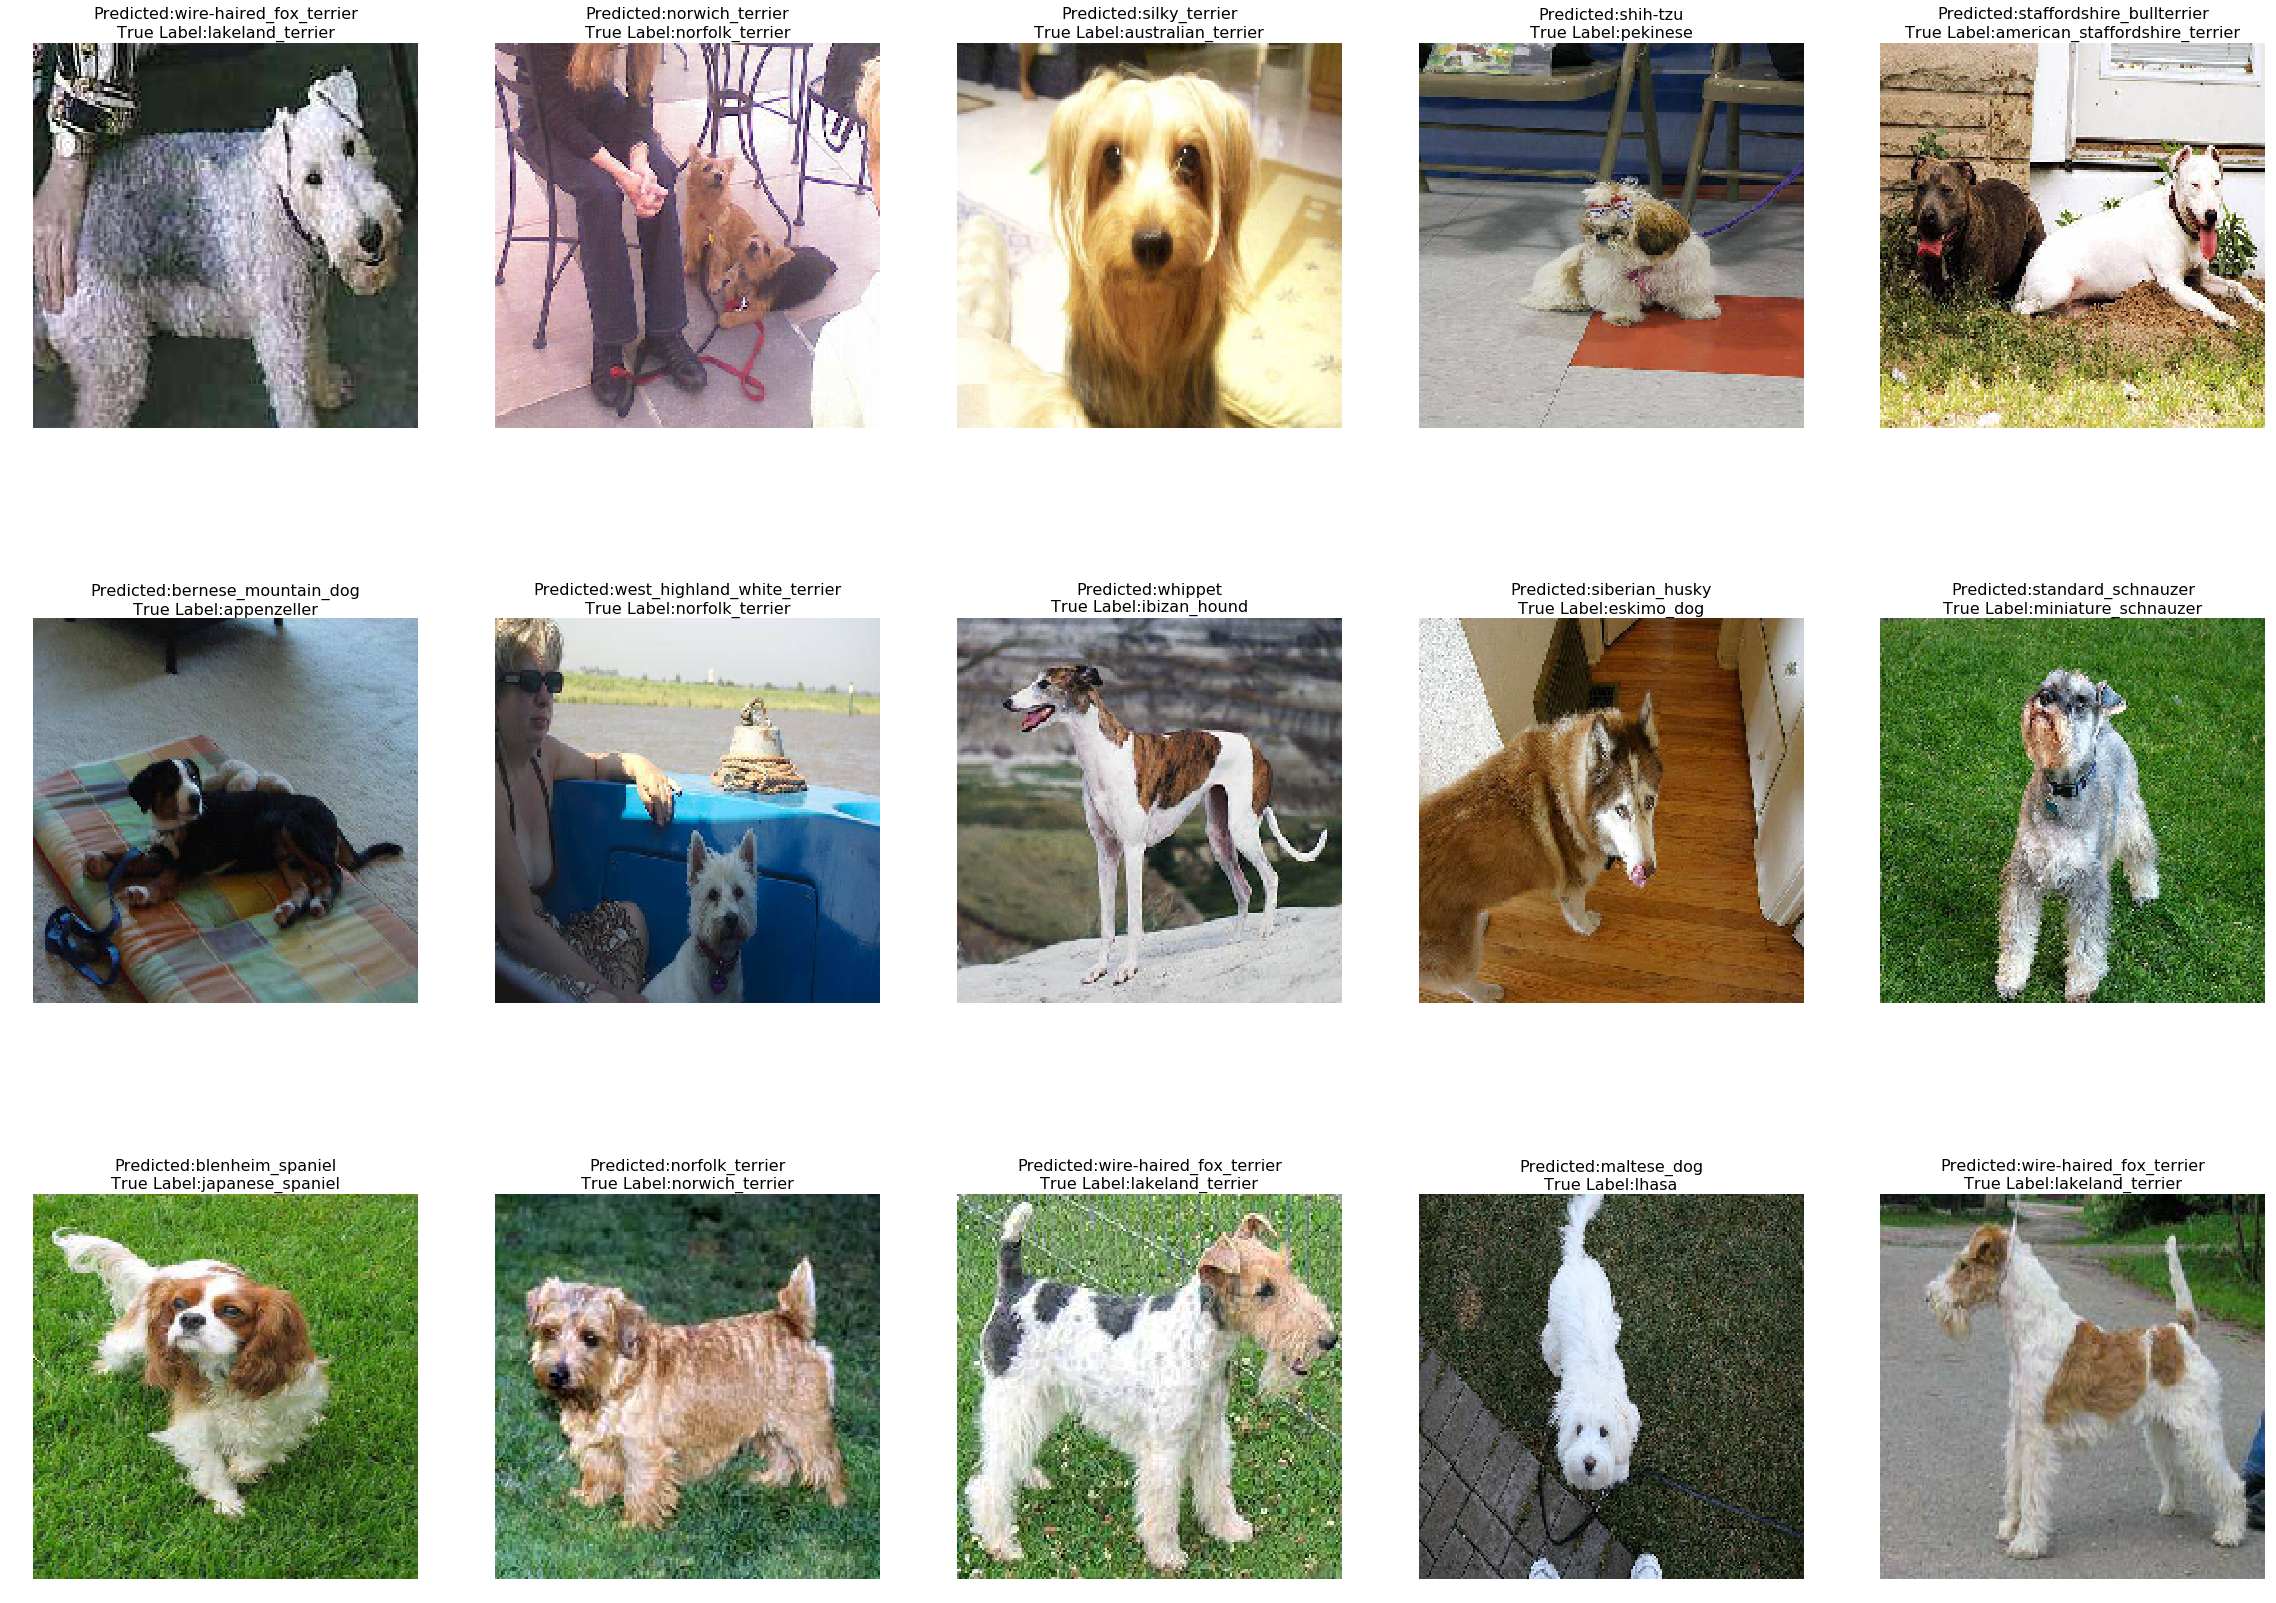

In [112]:
plot_most_confident(n=15, title="Most Wrong", accurate=False)

# Rerun on all data 
including the validation set, (i.e., `val_idxs=None`), so we use all available data to train.
Now we are training "blind" so we need to use the same parameters as before...
This work because we have already determined our model and process is good enough with a validation set first?

In [ ]:
lsz= 339
learn.set_data(get_data(lsz, bs, val_idxs=None)) #299,bs))
learn.freeze()

In [ ]:
%time learn.fit(1e-2, 4, cycle_len=1)

# Augment Data at Inference (Test) Time

Data augmentation at *inference* time (aka *test* time), aka *Test Time Augmentation*, or just *TTA*.
TTA makes predictions on the images of the (default is validation) set, but also makes predictions on a number of randomly augmented versions of them (by default, it uses the original image along with 4 randomly augmented versions). 
`learn.TTA` when `is_test == True` makes predictions on the test set.
**NB:** the 2nd returned parameter (_) is all zeroes, (hence ignored), since by definition, there are no labels in the test set.  Below takes about xx minutes to run

In [ ]:
%time log_preds,_ = learn.TTA(is_test=True)    

In [ ]:
log_preds.shape, type(log_preds)

TTA returned a np array with 5 predictions (log probability) for every one of the 10357 source images, for every one of the 120 classes. 

We then take the average of the 5 predictions. 

`probs` has the probabilities of each of the breeds computed as the mean for the 5 images.
`preds` gets the (index number via argmax) of the class (breed) with the highest probability of the 120 classes as a prediction for each image.

In [ ]:
probs = np.mean(np.exp(log_preds),0) 
preds = np.argmax(probs, axis=1)  

Obviously, we can't compute accuracy on the test set as they are unlabeled! :) 

JH: "about a 10-20% reduction in error on this dataset when using TTA at this point, which is an amazing result for such a quick and easy technique!"

# Review some Test Results 
(prior to submission)

In [ ]:
def plotstest(ims, figsize=(30,15), rows=6, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=12)
        plt.imshow(ims[i])

In [ ]:
PATH2='/home/german/data/dogsbreeds/'
imgs=[]; titles=[]
rows=3
for i in range(4*rows): #must be multiple of rows
    fn = data.test_ds.fnames[i]
    fullfname = f'{PATH2}'+fn   #full name   #print(fn[10:-4])
    imgs.append(Image.open(fullfname).resize((150,150))) #add it to the imgs list 
    titles.append(data.classes[np.argmax(probs[i])])     #Breed as title
plotstest(imgs,titles=titles, rows=rows)

# Create Submission

**File Format from Kaggle:**

id,affenpinscher,afghan_hound,african_hunting_dog,airedale,...., yorkshire_terrier 
000621fb3cbb32d8935728e48679680e,0.00833333333333333,0.00833333333333333,0.00833333333333333, ....

to avoid the first 5 chars "test/" and the 4 last chars of the filenames, we use `[5:-4]`

In [ ]:
df = pd.DataFrame(probs)   # Create a dataframe of the probabilities
df.columns = data.classes  # label the columns as the breeds (the classes)
df.insert(0, 'id', [o[5:-4] for o in data.test_ds.fnames]) #the short names of the files
#df.head()

In [ ]:
SUBMDIR = f'{PATH}subm/'  # submission directory
os.makedirs(SUBMDIR, exist_ok=True)
import time
SUBMF = SUBMDIR+"Kaggle"+time.strftime("%Y%m%d-%H%M%S")+'.gz'
df.to_csv(SUBMF, compression='gzip', index=False)

In [ ]:
from IPython.lib.display import FileLink
FileLink(SUBMF)  # to download via URL

# Individual Prediction (TBC)

We want to run a single image through a model to get a prediction?
Below we randomly choose one from the test set.
 Image must be transformed. `tfms_from_model` returns training transforms and validation transforms. In this case, we will use validation transform.
Everything that gets passed to or returned from a model is generally assumed to be in a mini-batch. Here we only have one image, but we have to turn that into a mini-batch of a single image. In other words, we need to create a tensor that is not just [rows, columns, channels] , but [number of images, rows, columns, channels].
im[None] : Numpy trick to add additional unit axis to the start.

In [ ]:
This does not yet work:
#trn_tfms, val_tfms = tfms_from_model(arch, sz)
#im = val_tfms(Image.open(PATH+fn)
#ipreds = learn.predict_array(im[None])

In [ ]:
TESTDIR = f'{PATH}test/'
import random
from PIL import Image
trn_tfms, val_tfms = tfms_from_model(arch, sz)

In [ ]:
# random.choice selects random element
# os.listdir lists in current directory
filename = random.choice(os.listdir(TESTDIR))
ffn = TESTDIR+filename
img1 = Image.open(ffn).resize((300,300))
img1

In [ ]:
ds = FilesIndexArrayDataset([filename], np.array([0]), val_tfms, TESTDIR) #PATH)
dl = DataLoader(ds)
individual_pred = learn.predict_dl(dl)   # It appends the /test directory
data.classes[np.argmax(individual_pred)]

# Save the predictions for evaluation

In [ ]:
PATH2='/home/german/data/dogsbreeds/'
SAVEPREDS = f'{PATH}subm/savepreds'
f2 = open(SAVEPREDS, 'a')
for i in range(len(data.test_ds.fnames)): 
    fns = data.test_ds.fnames[i]
    fullfname = f'{PATH2}'+fns   #full name   #print(fn[10:-4])
    fns_pred = data.classes[np.argmax(probs[i])]     #Breed as title
    mprint = fns[5:-4] + ', ' + fns_pred +'\n'
    f2.write(mprint)
f2.close()

# Shelter predictions

In [ ]:
#get the shelter images (independent test)
PATH2 = "data/dogsbreeds/shelter/"
files = !ls {PATH2} #| head
SAVEshelter = f'{PATH}subm/shelterpreds'
f2 = open(SAVEshelter, 'w')
trn_tfms, val_tfms = tfms_from_model(arch, sz)
for f in files: 
    ds = FilesIndexArrayDataset([f], np.array([0]), val_tfms, PATH2)
    dl = torch.utils.data.DataLoader(ds)
    preds = learn.predict_dl(dl)
    mprint = f[0:-12] + ',' + data.classes[np.argmax(preds)] + '\n'
    f2.write(mprint)
f2.close()

# END